# data preperation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint, uniform

sns.set_theme(style="dark")

In [ ]:
dfBTC = pd.read_csv('bitcoin_data.csv')
dfXTZ = pd.read_csv('tezos_data.csv')


#rename volume marketcap and price
dfBTC = dfBTC.rename(columns={'volume': 'btc_volume','market_cap': 'btc_market_cap','price': 'btc_price' })
dfXTZ = dfXTZ.rename(columns={'volume': 'xtz_volume','market_cap': 'xtz_market_cap','price': 'xtz_price' })


# conver to datetime
dfXTZ['date'] = pd.to_datetime(dfXTZ['date'])
dfBTC['date'] = pd.to_datetime(dfBTC['date'])

print(dfBTC.size, dfXTZ.size)
dfXTZ.head()

17592 10032


,date,xtz_price,xtz_market_cap,xtz_volume
0,2018-07-03,2.937866,0.000000e+00,3.172538e+06
1,2018-07-04,2.047985,0.000000e+00,1.426545e+07
2,2018-07-05,1.969392,1.196384e+09,6.492796e+06
3,2018-07-06,1.528033,9.282631e+08,8.681129e+06
4,2018-07-07,1.796304,1.091235e+09,1.617507e+07


# cleaning

In [3]:
#Filter dates so only days where theres values on both days will be used

dfBTCfiltered = dfBTC[dfBTC['date'].isin(dfXTZ['date'])]
dfXTZfiltered = dfXTZ[dfXTZ['date'].isin(dfBTCfiltered['date'])]

print(dfBTCfiltered.size,dfXTZfiltered.size)

10032 10032


In [4]:
#sort on dates if it wasnt already
dfBTCfiltered = dfBTCfiltered.sort_values('date').reset_index(drop=True)
dfXTZfiltered = dfXTZfiltered.sort_values('date').reset_index(drop=True)


Merge

In [5]:
df = pd.DataFrame({
    'date': dfBTCfiltered['date'],
    'btc_price': dfBTCfiltered['btc_price'],
    'xtz_price': dfXTZfiltered['xtz_price'],
    'btc_volume': dfBTCfiltered['btc_volume'],
    'xtz_volume': dfXTZfiltered['xtz_volume'],
    'btc_market_cap': dfBTCfiltered['btc_market_cap'],
    'xtz_market_cap': dfXTZfiltered['xtz_market_cap'],
})

# Add returns
df['btc_return'] = df['btc_price'].pct_change()
df['xtz_return'] = df['xtz_price'].pct_change()

# Target: Tezos price tomorrow
df['xtz_target'] = df['xtz_price'].shift(-1)

lag_map = {
    1: 'prev_day',
    2: '2d_ago',
    3: '3d_ago',
    4: '4d_ago',
    5: '5d_ago'
}

lag_features = [
    'btc_price', 'xtz_price', 'btc_volume', 'xtz_volume',
    'btc_market_cap', 'xtz_market_cap'
]

# Create lag features
for lag, suffix in lag_map.items():
    for feature in lag_features:
        df[f'{feature}_{suffix}'] = df[feature].shift(lag)

# Drop rows with NaNs (from shifts and returns)
df.dropna(inplace=True)

# Prepare feature matrix and target
feature_columns = [f'{feature}_{suffix}' for suffix in lag_map.values() for feature in lag_features]
features = df[feature_columns]
target = df['xtz_target']

Since we are trying to predict the price of XTZ, xtz_target is our target. 

Make a Train/Test split, we wont shuffle the data, as we want to keep the time series order.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False
)

X_train_lr = X_train.copy()
X_train_rf = X_train.copy()
X_train_xgb = X_train.copy()

X_test_lr = X_test.copy()
X_test_rf = X_test.copy()
X_test_xgb = X_test.copy()

y_train_lr = y_train.copy()
y_train_rf = y_train.copy()
y_train_xgb = y_train.copy()

y_test_lr = y_test.copy()
y_test_rf = y_test.copy()
y_test_xgb = y_test.copy()

In [7]:
scaler = StandardScaler()
X_train_lr = scaler.fit_transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

## Linear Regression

In [8]:

model = LinearRegression()
model.fit(X_train_lr, y_train_lr)

y_pred_lr = model.predict(X_test_lr)


In [9]:
feature_names = X_train.columns

rmse_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_lr))
r2_lr = r2_score(y_test_lr, y_pred_lr)

print("RMSE:", rmse_lr)
print("R² Score:", r2_lr)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
})
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)
print(coef_df)

RMSE: 0.08565891958738177
R² Score: 0.9084822390113605
                    Feature  Coefficient  AbsCoefficient
16    btc_market_cap_3d_ago    -6.443711        6.443711
12         btc_price_3d_ago     6.330865        6.330865
24         btc_price_5d_ago    -5.329808        5.329808
28    btc_market_cap_5d_ago     5.223098        5.223098
1        xtz_price_prev_day     1.179466        1.179466
22    btc_market_cap_4d_ago     1.162882        1.162882
18         btc_price_4d_ago    -1.108043        1.108043
11    xtz_market_cap_2d_ago    -0.992330        0.992330
6          btc_price_2d_ago     0.981611        0.981611
10    btc_market_cap_2d_ago    -0.935517        0.935517
7          xtz_price_2d_ago     0.834658        0.834658
17    xtz_market_cap_3d_ago     0.466339        0.466339
13         xtz_price_3d_ago    -0.338147        0.338147
19         xtz_price_4d_ago    -0.167931        0.167931
5   xtz_market_cap_prev_day     0.147423        0.147423
29    xtz_market_cap_5d_ago     0

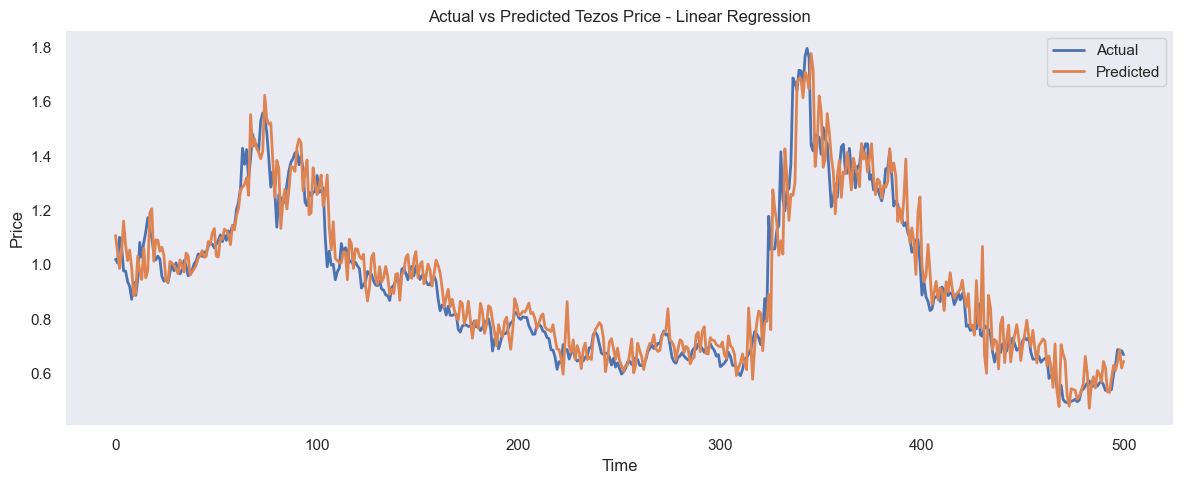

In [10]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_lr.values, label='Actual', linewidth=2)
plt.plot(y_pred_lr, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Tezos Price - Linear Regression')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## Random Forest

In [11]:
param_dist = {
    'n_estimators': randint(100, 501),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['auto', 'sqrt', 'log2']
}

# TimeSeriesSplit to respect temporal ordering
tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(random_state=42)

search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# Fit on training data only
search.fit(X_train_rf, y_train_rf)

# Evaluate on held-out test data
best_rf = search.best_estimator_
y_pred_rf = best_rf.predict(X_test_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
r2_rf = r2_score(y_test_rf, y_pred_rf)

print("Best Parameters:", search.best_params_)
print(f"Tuned RF RMSE: {rmse_rf:.4f}")
print(f"Tuned RF R² Score: {r2_rf:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Parameters: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 437}
Tuned RF RMSE: 0.0810
Tuned RF R² Score: 0.9182


## Feature Importance

In [12]:
feature_names = X_train.columns
importances = best_rf.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df['Importance'] = importance_df['Importance'].round(4)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)

                    Feature  Importance
0        xtz_price_prev_day      0.9633
1          xtz_price_2d_ago      0.0124
2   xtz_market_cap_prev_day      0.0066
3          xtz_price_3d_ago      0.0017
4         btc_volume_2d_ago      0.0011
5         btc_volume_5d_ago      0.0011
6       btc_volume_prev_day      0.0009
7          xtz_price_5d_ago      0.0008
8          xtz_price_4d_ago      0.0008
9          btc_price_3d_ago      0.0008
10      xtz_volume_prev_day      0.0007
11        xtz_volume_5d_ago      0.0007
12        xtz_volume_4d_ago      0.0007
13        btc_volume_3d_ago      0.0007
14    xtz_market_cap_3d_ago      0.0006
15        btc_volume_4d_ago      0.0006
16    xtz_market_cap_2d_ago      0.0006
17         btc_price_5d_ago      0.0005
18    xtz_market_cap_4d_ago      0.0005
19    btc_market_cap_5d_ago      0.0005
20       btc_price_prev_day      0.0005
21        xtz_volume_3d_ago      0.0005
22         btc_price_4d_ago      0.0005
23        xtz_volume_2d_ago      0.0005


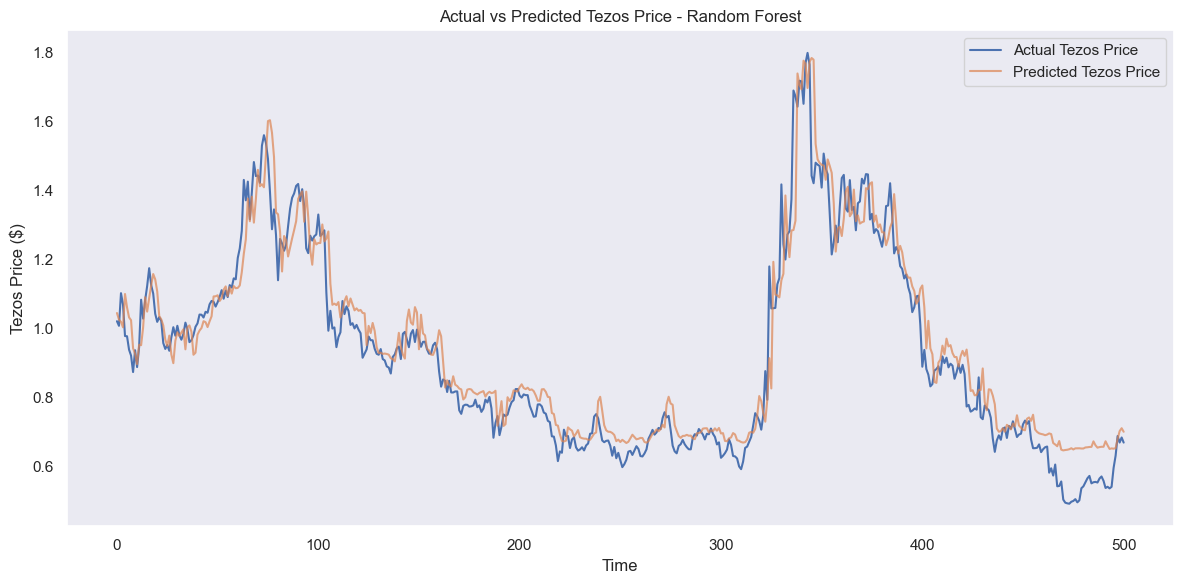

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rf.values, label='Actual Tezos Price')
plt.plot(y_pred_rf, label='Predicted Tezos Price', alpha=0.7)
plt.title('Actual vs Predicted Tezos Price - Random Forest')
plt.xlabel('Time')
plt.ylabel('Tezos Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

# XG BOOST

In [14]:
param_distributions = {
    'min_child_weight': randint(1, 11),      
    'gamma': uniform(0, 1),                   
    'n_estimators': randint(100, 501),           
    'max_depth': randint(3, 7),            
    'learning_rate': uniform(0.01, 0.09),   
    'subsample': uniform(0.6, 0.4), 
    'colsample_bytree': uniform(0.8, 0.2), 
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 1.5)
}

tscv = TimeSeriesSplit(n_splits=5)

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_xgb, y_train_xgb)

xgb_model = random_search.best_estimator_
y_pred_xgb = xgb_model.predict(X_test_xgb)

rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
r2_xgb = r2_score(y_test_xgb, y_pred_xgb)

print("Best parameters:", random_search.best_params_)
print("Best CV score (negative MSE):", random_search.best_score_)
print(f"Tuned XGBoost RMSE: {rmse_xgb:.4f}")
print(f"Tuned XGBoost R² Score: {r2_xgb:.4f}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Best parameters: {'colsample_bytree': 0.81161839041607, 'gamma': 0.1115122123212764, 'learning_rate': 0.056427571244109534, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 173, 'reg_alpha': 0.014693388654953843, 'reg_lambda': 1.0686410730079043, 'subsample': 0.7349382187076371}
Best CV score (negative MSE): -0.3587880650883255
Tuned XGBoost RMSE: 0.1127
Tuned XGBoost R² Score: 0.8415


In [15]:
importances = xgb_model.feature_importances_

# Create a DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
importance_df['Importance'] = importance_df['Importance'].round(4)
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(importance_df)

                    Feature  Importance
0          xtz_price_2d_ago      0.3894
1        xtz_price_prev_day      0.3878
2   xtz_market_cap_prev_day      0.0662
3          xtz_price_3d_ago      0.0465
4     xtz_market_cap_3d_ago      0.0101
5          xtz_price_5d_ago      0.0096
6          xtz_price_4d_ago      0.0089
7     xtz_market_cap_2d_ago      0.0069
8   btc_market_cap_prev_day      0.0054
9         btc_volume_5d_ago      0.0050
10         btc_price_4d_ago      0.0045
11       btc_price_prev_day      0.0044
12         btc_price_5d_ago      0.0040
13      btc_volume_prev_day      0.0040
14    btc_market_cap_2d_ago      0.0039
15        btc_volume_2d_ago      0.0038
16         btc_price_3d_ago      0.0035
17        btc_volume_3d_ago      0.0033
18         btc_price_2d_ago      0.0032
19        xtz_volume_5d_ago      0.0031
20      xtz_volume_prev_day      0.0030
21        xtz_volume_2d_ago      0.0028
22        xtz_volume_4d_ago      0.0028
23    btc_market_cap_4d_ago      0.0028


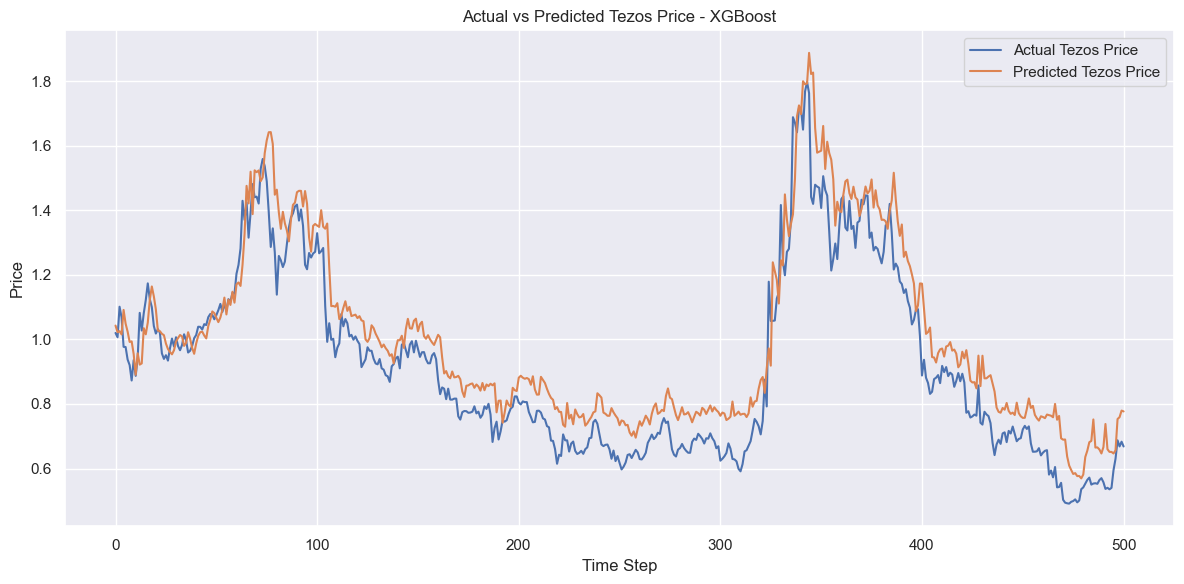

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_xgb.values, label='Actual Tezos Price')
plt.plot(y_pred_xgb, label='Predicted Tezos Price')
plt.title('Actual vs Predicted Tezos Price - XGBoost')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Conclusion

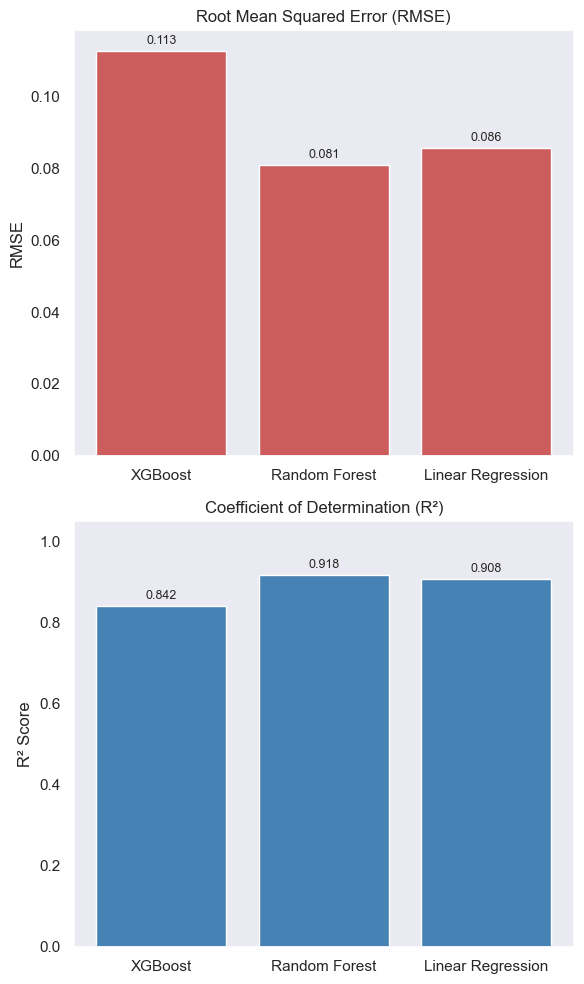

In [29]:
data = {
    'XGBoost': {'RMSE': rmse_xgb, 'R²': r2_xgb},
    'Random Forest': {'RMSE': rmse_rf, 'R²': r2_rf},
    'Linear Regression': {'RMSE': rmse_lr, 'R²': r2_lr}
}

df = pd.DataFrame(data).T

fig, axes = plt.subplots(2, 1, figsize=(6, 10))  # Taller figure for vertical layout

# RMSE vertical bar plot
axes[0].bar(df.index, df['RMSE'], color='indianred')
axes[0].set_title('Root Mean Squared Error (RMSE)')
axes[0].set_ylabel('RMSE')
for i, val in enumerate(df['RMSE']):
    axes[0].text(i, val + 0.001, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

# R² vertical bar plot
axes[1].bar(df.index, df['R²'], color='steelblue')
axes[1].set_title('Coefficient of Determination (R²)')
axes[1].set_ylabel('R² Score')
axes[1].set_ylim(0, 1.05)
for i, val in enumerate(df['R²']):
    axes[1].text(i, val + 0.01, f'{val:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# Check for overfitting

In [18]:
# TRAIN predictions
y_pred_train_xgb = xgb_model.predict(X_train_xgb)
y_pred_train_rf = best_rf.predict(X_train_rf)
y_pred_train_lr = model.predict(X_train_lr)

# TEST predictions
y_pred_test_xgb = xgb_model.predict(X_test_xgb)
y_pred_test_rf = best_rf.predict(X_test_rf)
y_pred_test_lr = model.predict(X_test_lr)

# Error metrics
def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

metrics = {
    "XGBoost": {
        "Train": evaluate(y_train, y_pred_train_xgb),
        "Test": evaluate(y_test, y_pred_test_xgb)
    },
    "Random Forest": {
        "Train": evaluate(y_train, y_pred_train_rf),
        "Test": evaluate(y_test, y_pred_test_rf)
    },
    "Linear Regression": {
        "Train": evaluate(y_train, y_pred_train_lr),
        "Test": evaluate(y_test, y_pred_test_lr)
    }
}

for model, result in metrics.items():
    print(f"\n{model}:")
    print(f"  Train RMSE: {result['Train'][0]:.4f}, R²: {result['Train'][1]:.4f}")
    print(f"  Test  RMSE: {result['Test'][0]:.4f}, R²: {result['Test'][1]:.4f}")


XGBoost:
  Train RMSE: 0.1117, R²: 0.9948
  Test  RMSE: 0.1127, R²: 0.8415

Random Forest:
  Train RMSE: 0.1443, R²: 0.9912
  Test  RMSE: 0.0810, R²: 0.9182

Linear Regression:
  Train RMSE: 0.2471, R²: 0.9743
  Test  RMSE: 0.0857, R²: 0.9085


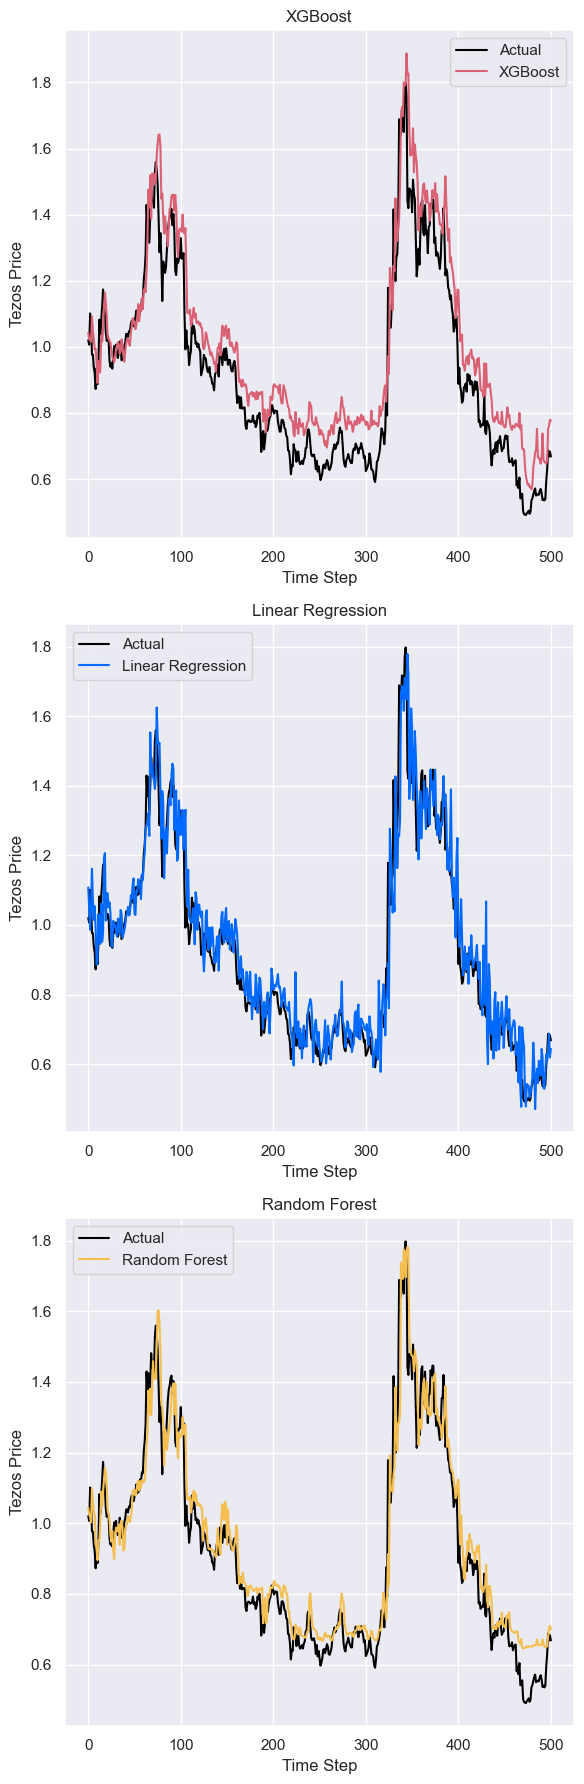

In [28]:
plt.figure(figsize=(6, 18))  # Taller, portrait-style layout

# XGBoost subplot
plt.subplot(3, 1, 1)
plt.plot(y_test_xgb.values, label='Actual', color='black')
plt.plot(y_pred_xgb, label='XGBoost', color='#DA6073')
plt.title('XGBoost')
plt.xlabel('Time Step')
plt.ylabel('Tezos Price')
plt.legend()
plt.grid(True)

# Linear Regression subplot
plt.subplot(3, 1, 2)
plt.plot(y_test_xgb.values, label='Actual', color='black')
plt.plot(y_pred_lr, label='Linear Regression', color='#0069FF')
plt.title('Linear Regression')
plt.xlabel('Time Step')
plt.ylabel('Tezos Price')
plt.legend()
plt.grid(True)

# Random Forest subplot
plt.subplot(3, 1, 3)
plt.plot(y_test_xgb.values, label='Actual', color='black')
plt.plot(y_pred_rf, label='Random Forest', color='#F4BF50')
plt.title('Random Forest')
plt.xlabel('Time Step')
plt.ylabel('Tezos Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
